# Normal DCGAN

In [26]:
import os
import numpy as np
import math
import random
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch

from torchvision.utils import save_image
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [41]:
%matplotlib inline
os.makedirs('images', exist_ok=True)
os.makedirs('data', exist_ok=True)

# Enable GPU
cuda = True if torch.cuda.is_available() else False

Configuring dataset and checking images

In [24]:
# Configure data loader and image parameters

img_dim = 32
img_channels = 3

os.makedirs('./data/cifar10', exist_ok=True)

transform=transforms.Compose([
    transforms.Resize(img_dim),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.CIFAR10(root='./data/cifar10', train=True, download=True,
                       transform=transform)

def show(img):
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


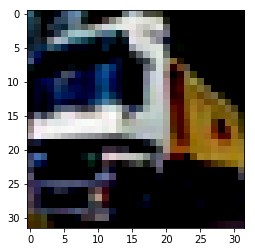

In [40]:
i, _ = dataset[seed]
show(i)

Parameters

In [7]:
# General

epochs = 50
batch_size = 64
n_cpu = 1
samples = 500
seed = 1

# Hyperparameters: Adam optimizer parameters (learning rate and momentum decay)

lr = 0.0002
b1 = 0.5
b2 = 0.999

# Dimensions of latent space, GPU

device = torch.device("cuda:0" if cuda else "cpu")
ngpu = 1
nz = 100
ngf = img_dim
ndf = img_dim
nc = img_channels

Setting seed

In [8]:
# CPU
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# GPU
if torch.cuda.is_available():
        print("Using cuda.")
        torch.cuda.manual_seed_all(seed)

Generator

In [9]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

Discriminator

In [11]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

Function to initialise weights

In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

Initialising and configuring metrics

In [19]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
print(netD)

criterion = nn.BCELoss()

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(b1, b2))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(b1, b2))

if cuda:
    netG.cuda()
    netD.cuda()
    criterion.cuda()

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
Discriminator(
  (main)

Training

In [ ]:
gen_loss = []
disc_loss = []

for epoch in range(opt.niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, epochs, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        gen_loss.append(errG.item())
        disc_loss.append(errD.item())
        
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    './images/real_samples.png',
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),
                    './images/fake_samples_epoch_%03d.png' % (epoch),
                    normalize=True)
            
    plt.plot( 'Epoch', 'Loss', data=disc_loss, marker='', color='olive', linewidth=2, label='Loss_D')
    plt.plot( 'Epoch', 'Loss', data=gen_loss, marker='', color='blue', linewidth=2, label='Loss_G')
    plt.show()

    # do checkpointing
    torch.save(netG.state_dict(), './saved/netG_epoch_%d.pth' % (epoch))
    torch.save(netD.state_dict(), './saved/netD_epoch_%d.pth' % (epoch))